In [18]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

# Объединяем test с gender_submission по PassengerId, чтобы добавить колонку Survived
test_merged = pd.merge(test, gender_submission, on='PassengerId')

# Объединяем train и test_merged в единый датафрейм
full_data = pd.concat([train, test_merged], ignore_index=True)

# Сохраняем в новый файл
full_data.to_csv('full_titanic.csv', index=False)
full_data[(full_data['PassengerId'] == 5)].sample()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


анализ данных

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


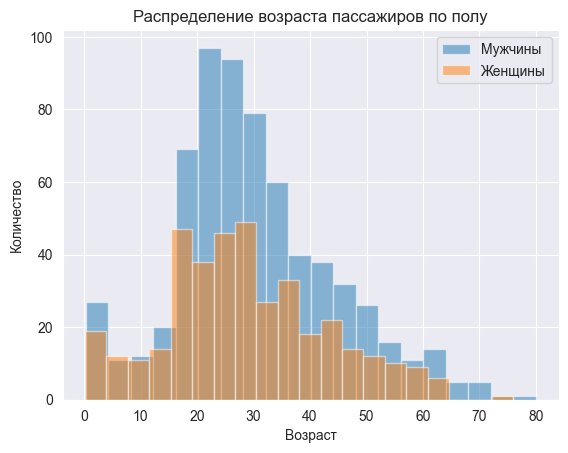

In [5]:
print(full_data.isnull().sum())
import matplotlib.pyplot as plt

men = full_data[full_data['Sex'] == 'male']['Age'].dropna()
women = full_data[full_data['Sex'] == 'female']['Age'].dropna()

plt.hist(men, bins=20, alpha=0.5, label='Мужчины')
plt.hist(women, bins=20, alpha=0.5, label='Женщины')
plt.legend()
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста пассажиров по полу')
plt.show()

def fill_age(row):
    if pd.isna(row['Age']):
        # Используем медиану по классу и полу
        return full_data[(full_data['Pclass'] == row['Pclass']) &
                         (full_data['Sex'] == row['Sex'])]['Age'].median()
    return row['Age']

full_data['Age'] = full_data.apply(fill_age, axis=1)

Разбить возраст на интервалы

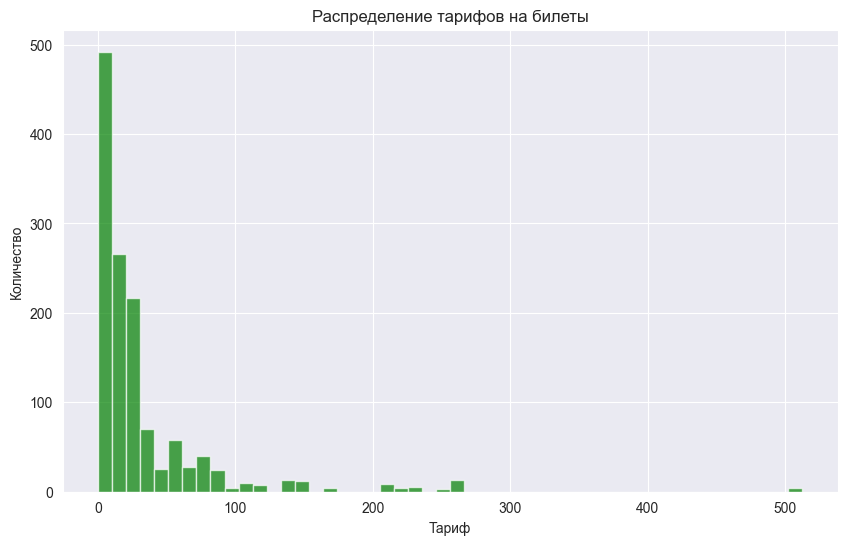

Найдено подозрительных записей 1 класса: 7


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Cat
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0,NaN,S,средний возраст
815,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0,B102,S,NaN
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,средний возраст
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,NaN
1263,1264,0,1,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0,B52 B54 B56,S,средний возраст
806,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0,A36,S,средний возраст
1157,1158,0,1,"Chisholm, Mr. Roderick Robert Crispin",male,NaN,0,0,112051,0.0,NaN,S,NaN


In [20]:
bins = [0, 18, 60, full_data['Age'].max() + 1]
labels = ['дети', 'средний возраст', 'старшие']
full_data['Age_Cat'] = pd.cut(full_data['Age'], bins=bins, labels=labels, right=False)
plt.figure(figsize=(10, 6))
plt.hist(full_data['Fare'], bins=50, color='green', alpha=0.7)
plt.xlabel('Тариф')
plt.ylabel('Количество')
plt.title('Распределение тарифов на билеты')
plt.show()
suspicious_1class = full_data[(full_data['Pclass'] == 1) & (full_data['Fare'] == 0) ]
if not suspicious_1class.empty:
    print(f"Найдено подозрительных записей 1 класса: {len(suspicious_1class)}")
    suspicious_1class.to_csv('suspicious_fares.csv', index=False)
else:
    print("Подозрительных записей 1 класса не найдено")

suspicious_1class.sample(len(suspicious_1class), replace=False)

In [11]:
full_data['Family_Size'] = full_data['SibSp'] + full_data['Parch'] + 1
lsuspicious_1class = full_data[(full_data['Pclass'] == 1) & (full_data['Fare'] < 10)]
if not suspicious_1class.empty:
    print(f"Найдено подозрительных записей 1 класса: {len(suspicious_1class)}")
    suspicious_1class.to_csv('suspicious_fares.csv', index=False)
else:
    print("Подозрительных записей 1 класса не найдено")

Найдено подозрительных записей 1 класса: 8


выявление закономерностей

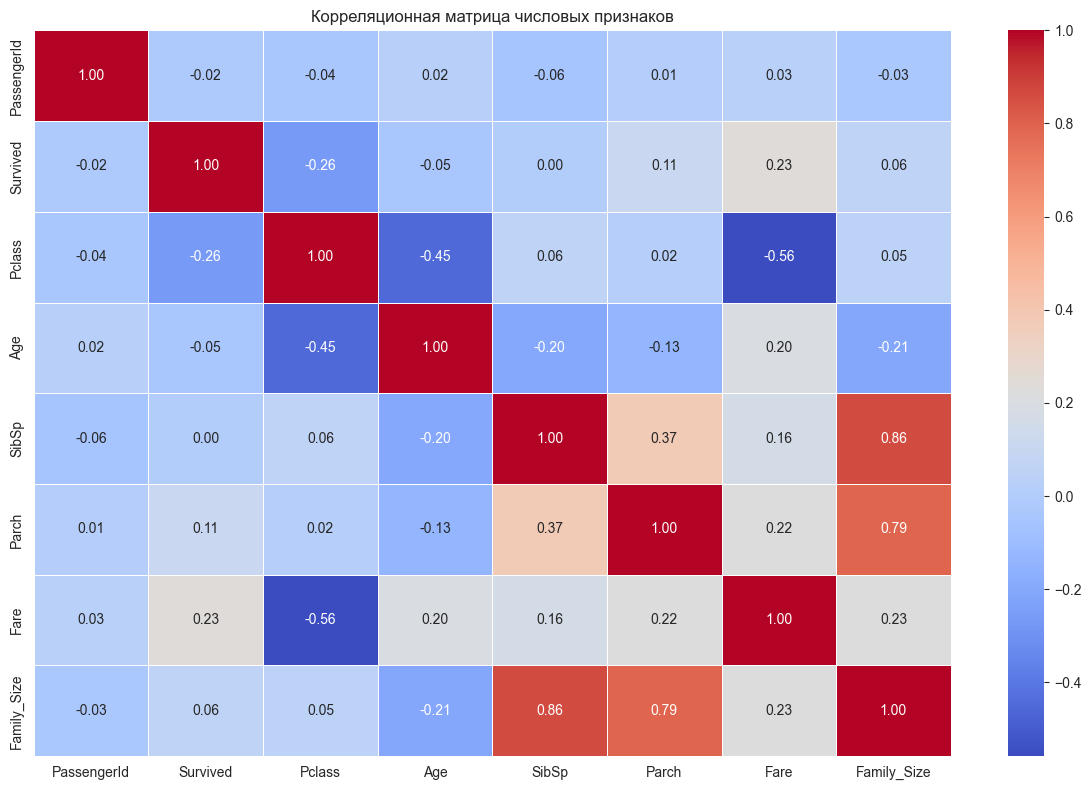

In [12]:
import seaborn as sns

plt.figure(figsize=(12, 8))
numeric = full_data.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

выделение признаков


АНАЛИЗ ВЫЖИВАЕМОСТИ

1. Выживаемость по полу:
Sex
female    0.82618
male      0.12930
Name: Survived, dtype: float64

2. Выживаемость по классу:
Pclass
1    0.575851
2    0.422383
3    0.269394
Name: Survived, dtype: float64

3. Выживаемость по возрастной категории:
Age_Cat
дети               0.506494
средний возраст    0.360538
старшие            0.350000
Name: Survived, dtype: float64

4. Выживаемость по размеру семьи:
Family_Size
1     0.292405
2     0.531915
3     0.559748
4     0.720930
5     0.227273
6     0.200000
7     0.312500
8     0.125000
11    0.181818
Name: Survived, dtype: float64

5. Общая статистика:
Всего пассажиров: 1309
Выживших: 494 (37.7%)
Средний возраст: 29.3
Средний тариф: 33.30


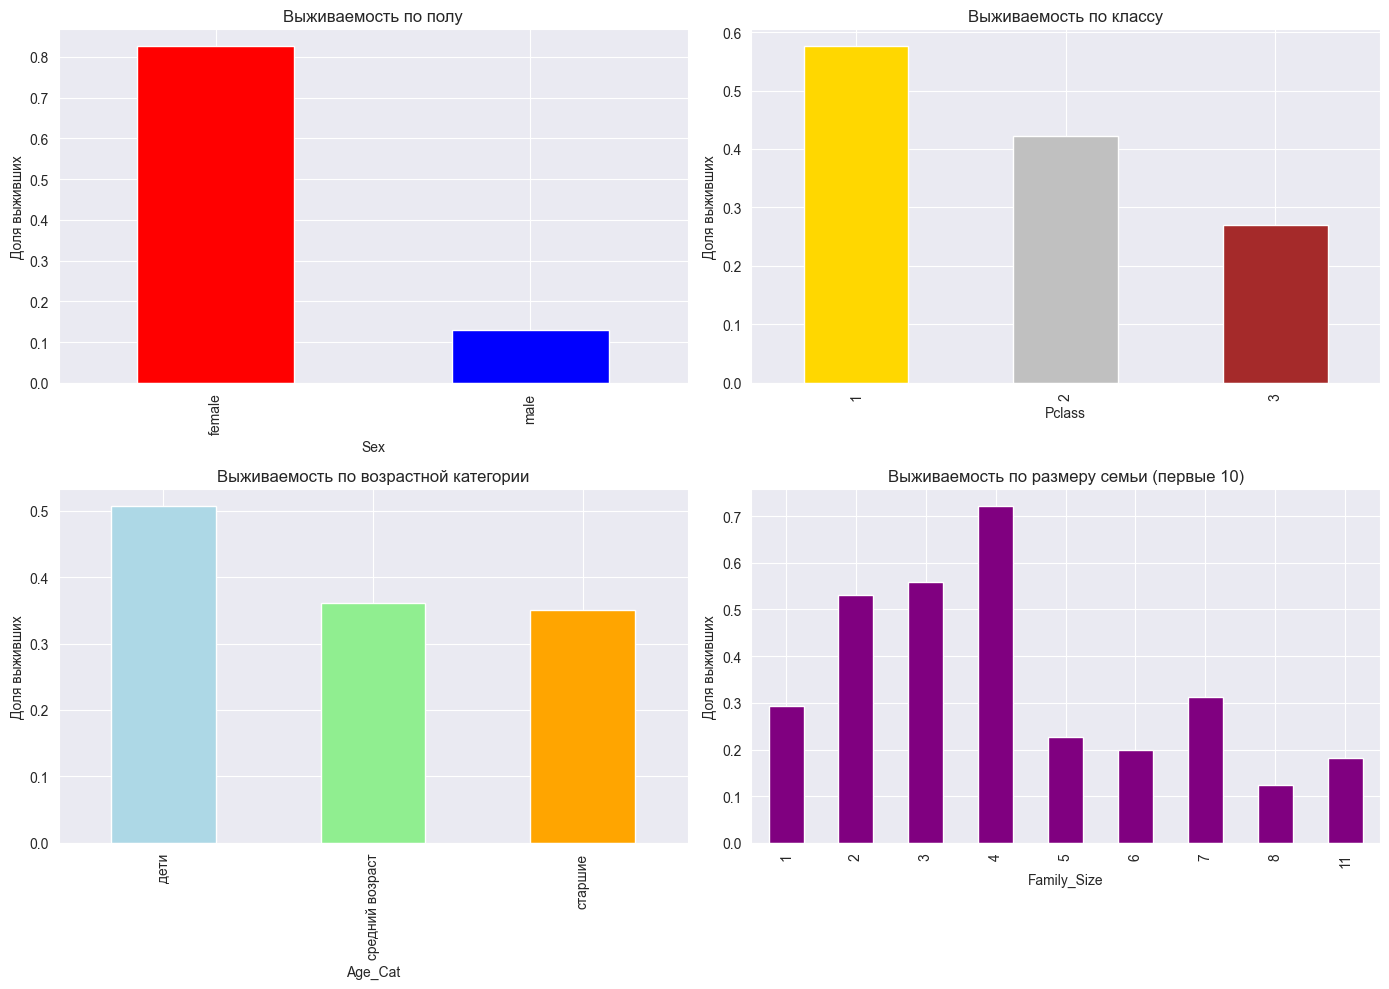

In [13]:
# Анализ выживаемости
print("\n" + "="*50)
print("АНАЛИЗ ВЫЖИВАЕМОСТИ")
print("="*50)

# Выживаемость по полу
print("\n1. Выживаемость по полу:")
sex_survival = full_data.groupby('Sex')['Survived'].mean()
print(sex_survival)

# Выживаемость по классу
print("\n2. Выживаемость по классу:")
class_survival = full_data.groupby('Pclass')['Survived'].mean()
print(class_survival)

# Выживаемость по возрастной категории (с явным указанием observed)
print("\n3. Выживаемость по возрастной категории:")
age_cat_survival = full_data.groupby('Age_Cat', observed=False)['Survived'].mean()
print(age_cat_survival)

# Выживаемость по размеру семьи
print("\n4. Выживаемость по размеру семьи:")
family_survival = full_data.groupby('Family_Size')['Survived'].mean()
print(family_survival)

# Дополнительная аналитика
print("\n5. Общая статистика:")
print(f"Всего пассажиров: {len(full_data)}")
print(f"Выживших: {full_data['Survived'].sum()} ({full_data['Survived'].mean()*100:.1f}%)")
print(f"Средний возраст: {full_data['Age'].mean():.1f}")
print(f"Средний тариф: {full_data['Fare'].mean():.2f}")

# Визуализация выживаемости по категориям
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Выживаемость по полу
sex_survival.plot(kind='bar', ax=axes[0, 0], color=['red', 'blue'])
axes[0, 0].set_title('Выживаемость по полу')
axes[0, 0].set_ylabel('Доля выживших')

# Выживаемость по классу
class_survival.plot(kind='bar', ax=axes[0, 1], color=['gold', 'silver', 'brown'])
axes[0, 1].set_title('Выживаемость по классу')
axes[0, 1].set_ylabel('Доля выживших')

# Выживаемость по возрастной категории
age_cat_survival.plot(kind='bar', ax=axes[1, 0], color=['lightblue', 'lightgreen', 'orange'])
axes[1, 0].set_title('Выживаемость по возрастной категории')
axes[1, 0].set_ylabel('Доля выживших')

# Выживаемость по размеру семьи (первые 10 значений)
family_survival.head(100).plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Выживаемость по размеру семьи (первые 10)')
axes[1, 1].set_ylabel('Доля выживших')

plt.tight_layout()
plt.show()

модель

In [14]:
prob = full_data.groupby(['Sex', 'Pclass'])['Survived'].mean().reset_index(name='Prob_Surv')
full_data = full_data.merge(prob, on=['Sex', 'Pclass'], how='left')
full_data.rename(columns={'Prob_Surv': 'Model_Surv'}, inplace=True)

full_data['Predicted'] = (full_data['Model_Surv'] > 0.5).astype(int)
accuracy = (full_data['Predicted'] == full_data['Survived']).mean()
print(accuracy)

def rule_survived(row):
    if (row['Sex'] == 'female' or row['Age'] < 18) and row['Pclass'] != 3:
        return 1
    return 0

full_data['Rule_Surv'] = full_data.apply(rule_survived, axis=1)
rule_accuracy = (full_data['Rule_Surv'] == full_data['Survived']).mean()
print(rule_accuracy)

0.8548510313216195
0.8029029793735676
